In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import networkx as nx
from sklearn.decomposition import PCA

In [67]:
from astropy.table import Table
import numpy as np
import os
import itertools
import scipy.spatial as spatial

def get_filament_outputs(datafile, randomfile):
    # Paths reales
    data_dir = r"C:\Users\USUARIO\Desktop\CosmicWeb_BGS_ASTRA\XYZ_outputs\XYZ_data"
    random_dir = r"C:\Users\USUARIO\Desktop\CosmicWeb_BGS_ASTRA\06_astrology_random_MC\data_100_random"

    # Leer archivos .ecsv con encabezado usando Astropy
    data_path = os.path.join(data_dir, datafile)
    random_path = os.path.join(random_dir, randomfile)

    print(f"Cargando data: {data_path}")
    print(f"Cargando random: {random_path}")

    data_table = Table.read(data_path, format="ascii.ecsv")
    random_table = Table.read(random_path, format="ascii.ecsv")

    data = np.array([data_table["X"], data_table["Y"], data_table["Z"]]).T
    random = np.array([random_table["X"], random_table["Y"], random_table["Z"]]).T

    n_d = len(data)
    n_r = len(random)
    assert n_d == n_r, f"Mismatch en cantidad de puntos: data={n_d}, random={n_r}"

    all_points = np.vstack([data, random])
    tri = spatial.Delaunay(all_points)

    # Obtener pares
    all_pairs = []
    for simplex in tri.simplices:
        combs = list(itertools.combinations(simplex, 2))
        for pair in combs:
            all_pairs.append(sorted(pair))

    all_pairs = np.array(all_pairs)
    unique_pairs = np.unique(all_pairs, axis=0)

    # Conteo hacia data y random
    n_to_random = np.zeros(n_d + n_r)
    n_to_data = np.zeros(n_d + n_r)

    for a, b in unique_pairs:
        if a < n_d:
            n_to_data[b] += 1
        else:
            n_to_random[b] += 1

        if b < n_d:
            n_to_data[a] += 1
        else:
            n_to_random[a] += 1

    count_data = np.vstack([n_to_data[:n_d], n_to_random[:n_d]]).T

    # Filtrar pares entre puntos reales
    is_pair_data = (unique_pairs[:, 0] < n_d) & (unique_pairs[:, 1] < n_d)
    pairs_data = unique_pairs[is_pair_data]

    print(f"{len(pairs_data)} pares entre puntos reales encontrados.")
    print(f"count_data tiene shape: {count_data.shape}")

    return data, pairs_data, count_data

In [65]:
datafile = "BGS_0_clustering_data.ecsv"
randomfile = "BGS_0clustering_random0.ecsv"

data, pairs_data, count_data = get_filament_outputs(datafile, randomfile)

Cargando data: C:\Users\USUARIO\Desktop\CosmicWeb_BGS_ASTRA\XYZ_outputs\XYZ_data\BGS_0_clustering_data.ecsv
Cargando random: C:\Users\USUARIO\Desktop\CosmicWeb_BGS_ASTRA\06_astrology_random_MC\data_100_random\BGS_0clustering_random0.ecsv
51483 pares entre puntos reales encontrados.
count_data tiene shape: (11863, 2)


In [17]:
import networkx as nx

# Construir grafo de puntos conectados
G = nx.Graph()
for a, b in pairs_data:
    G.add_edge(int(a), int(b))  # Aseguramos que sean enteros

# Encontrar todos los componentes conexos
components = list(nx.connected_components(G))

# Escoger el más grande como ejemplo de filamento
largest_component = max(components, key=len)
print(f"Componente más grande: {len(largest_component)} puntos conectados")

# Crear subgrafo con ese grupo
subgraph = G.subgraph(largest_component)

🔗 Componente más grande: 11766 puntos conectados


In [18]:
# Extraer índices como lista ordenada
group_indices = sorted(list(largest_component))

# Extraer coordenadas de los puntos reales
group_coords = data[group_indices]

In [20]:
from sklearn.decomposition import PCA

def rotate_with_pca(coords):
    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(coords)
    return coords_rotated, pca.explained_variance_ratio_, pca.components_

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np
import pandas as pd

def visualize_and_diagnose_rosetta(data, pairs_data, count_data, r_threshold=0.9, min_size=10):
    # Paso 1 – Calcular r y clasificar
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

    df = pd.DataFrame({'r': r})
    df['class'] = None
    df.loc[(df['r'] >= -1.0) & (df['r'] <= -0.9), 'class'] = 'void'
    df.loc[(df['r'] >  -0.9) & (df['r'] <=  0.0), 'class'] = 'sheet'
    df.loc[(df['r'] >   0.0) & (df['r'] <=  0.5), 'class'] = 'filament'
    df.loc[(df['r'] >   0.5) & (df['r'] <=  1.0), 'class'] = 'knot'

    # Paso 2 – Filtrar nodos y pares
    valid_ids = set(np.where(r >= r_threshold)[0])
    filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_ids and b in valid_ids]

    # Paso 3 – Construir grafo con pares filtrados
    G = nx.Graph()
    G.add_edges_from(filtered_pairs)
    components = list(nx.connected_components(G))
    sizes = sorted([len(c) for c in components], reverse=True)

    # Paso 4 – Visualización en 3D con PCA
    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(data)
    id_to_pca = dict(zip(range(len(data)), coords_rotated))

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Fondo: todos los datos reales
    ax.scatter(coords_rotated[:, 0], coords_rotated[:, 1], coords_rotated[:, 2],
               s=1, color='black', alpha=0.2, label='data')

    # Filamentos: por componente
    cmap = cm.get_cmap("tab20")
    for i, comp in enumerate(components):
        if len(comp) < min_size:
            continue
        group_coords = np.array([id_to_pca[idx] for idx in comp])
        color = cmap(i % 20)
        ax.scatter(group_coords[:, 0], group_coords[:, 1], group_coords[:, 2],
                   s=5, color=color)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(f"Filamentos r ≥ {r_threshold}")
    plt.tight_layout()
    plt.show()

    # Paso 5 – Diagnóstico numérico
    print(f"\nTotal de componentes: {len(sizes)}")
    print("Tamaños de los 10 más grandes:")
    for i, s in enumerate(sizes[:10]):
        print(f"  {i+1}. {s} puntos")

    total_nodes = sum(sizes)
    prop = total_nodes / len(data)
    print(f"\n{total_nodes} de {len(data)} puntos (~{100*prop:.2f}%) están en filamentos (r ≥ {r_threshold})")

    print("\nConteo por clase estructural (r):")
    print(df['class'].value_counts())

    return df, G, components

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22356\2524264679.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")


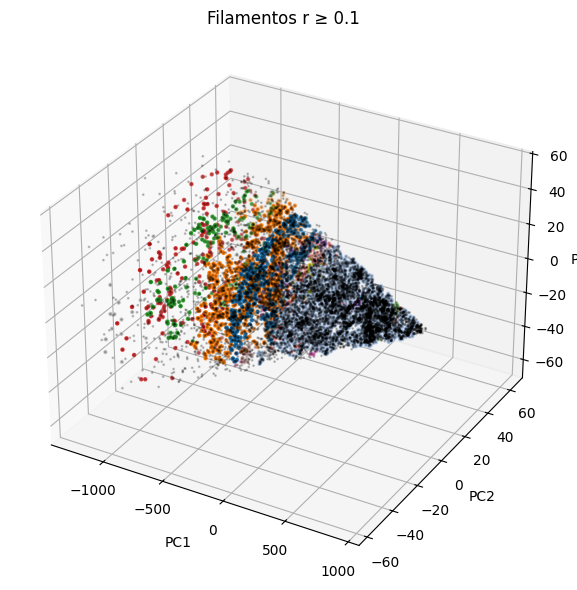


Total de componentes: 79
Tamaños de los 10 más grandes:
  1. 4148 puntos
  2. 1165 puntos
  3. 486 puntos
  4. 254 puntos
  5. 189 puntos
  6. 185 puntos
  7. 140 puntos
  8. 130 puntos
  9. 91 puntos
  10. 82 puntos

7473 de 11863 puntos (~62.99%) están en filamentos (r ≥ 0.1)

Conteo por clase estructural (r):
class
filament    4242
sheet       3806
knot        3782
void          33
Name: count, dtype: int64


In [50]:
df, G, components = visualize_and_diagnose_rosetta(data, pairs_data, count_data, r_threshold=0.1)

In [51]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

def plot_structures_3D_grid(data, pairs_data, count_data):
    # Calcular r
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

    # PCA rotación global
    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(data)
    id_to_pca = dict(zip(range(len(data)), coords_rotated))

    # Umbrales por clase
    structure_thresholds = {
        'void':     [-1.0, -0.95, -0.9],
        'sheet':    [-0.7, -0.5, -0.2],
        'filament': [0.1, 0.3, 0.5],
        'knot':     [0.6, 0.8, 0.95],
    }

    fig = plt.figure(figsize=(15, 15))
    cmap = cm.get_cmap("tab20")

    for row_idx, (structure, thresholds) in enumerate(structure_thresholds.items()):
        for col_idx, threshold in enumerate(thresholds):
            ax = fig.add_subplot(4, 3, row_idx*3 + col_idx + 1, projection='3d')

            # Seleccionar nodos válidos por umbral
            if structure in ['void', 'sheet']:
                valid_ids = set(np.where(r <= threshold)[0])
            else:
                valid_ids = set(np.where(r >= threshold)[0])

            # Filtrar pares
            filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_ids and b in valid_ids]

            # Grafo
            G = nx.Graph()
            G.add_edges_from(filtered_pairs)
            components = list(nx.connected_components(G))

            # Graficar
            ax.scatter(coords_rotated[:, 0], coords_rotated[:, 1], coords_rotated[:, 2],
                       s=1, color='black', alpha=0.1)

            for i, comp in enumerate(components):
                if len(comp) < 10:
                    continue
                group_coords = np.array([id_to_pca[idx] for idx in comp])
                color = cmap(i % 20)
                ax.scatter(group_coords[:, 0], group_coords[:, 1], group_coords[:, 2],
                           s=4, color=color)

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.set_title(f"{structure}, r {'≥' if structure in ['filament','knot'] else '≤'} {threshold}")

    plt.tight_layout()
    plt.show()

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np
import pandas as pd

def plot_3d_by_structure(data, pairs_data, count_data):
    # Calcular r
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r_values = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

    # Clasificar
    def classify_r(r):
        if -1.0 <= r <= -0.9:
            return "void"
        elif -0.9 < r <= 0.0:
            return "sheet"
        elif 0.0 < r <= 0.5:
            return "filament"
        elif 0.5 < r <= 1.0:
            return "knot"
        return "unknown"
    classes = np.array([classify_r(r) for r in r_values])

    # Thresholds por clase
    thresholds = {
        "void": [-0.95, -0.925, -0.9],
        "sheet": [-0.6, -0.3, -0.05],
        "filament": [0.1, 0.3, 0.49],
        "knot": [0.6, 0.75, 0.9]
    }

    # PCA
    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(data)
    id_to_pca = dict(zip(range(len(data)), coords_rotated))

    # Figura 3D
    fig = plt.figure(figsize=(15, 12))
    cmap = cm.get_cmap("tab10")
    structure_list = ["void", "sheet", "filament", "knot"]

    for row, struct in enumerate(structure_list):
        for col, r_thresh in enumerate(thresholds[struct]):
            if struct == "void":
                valid_ids = np.where((classes == struct) & (r_values <= r_thresh))[0]
            else:
                valid_ids = np.where((classes == struct) & (r_values >= r_thresh))[0]
            valid_set = set(valid_ids)

            filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_set and b in valid_set]
            G = nx.Graph()
            G.add_edges_from(filtered_pairs)
            components = sorted(nx.connected_components(G), key=lambda x: -len(x))

            ax = fig.add_subplot(4, 3, row * 3 + col + 1, projection='3d')
            for i, comp in enumerate(components[:3]):
                coords = np.array([id_to_pca[idx] for idx in comp])
                ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=3, color=cmap(i))
            ax.set_title(f"{struct}\n{'r ≤' if struct=='void' else 'r ≥'} {r_thresh}")
            ax.axis('off')

    fig.suptitle("🔭 Estructuras 3D por clase y umbral r", fontsize=16)
    plt.tight_layout()
    plt.show()

In [54]:
def plot_2d_by_structure(data, pairs_data, count_data):
    # Calcular r
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r_values = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

    def classify_r(r):
        if -1.0 <= r <= -0.9:
            return "void"
        elif -0.9 < r <= 0.0:
            return "sheet"
        elif 0.0 < r <= 0.5:
            return "filament"
        elif 0.5 < r <= 1.0:
            return "knot"
        return "unknown"
    classes = np.array([classify_r(r) for r in r_values])

    thresholds = {
        "void": [-0.95, -0.925, -0.9],
        "sheet": [-0.6, -0.3, -0.05],
        "filament": [0.1, 0.3, 0.49],
        "knot": [0.6, 0.75, 0.9]
    }

    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(data)
    id_to_pca = dict(zip(range(len(data)), coords_rotated))

    fig = plt.figure(figsize=(15, 12))
    cmap = cm.get_cmap("tab10")
    structure_list = ["void", "sheet", "filament", "knot"]

    for row, struct in enumerate(structure_list):
        for col, r_thresh in enumerate(thresholds[struct]):
            if struct == "void":
                valid_ids = np.where((classes == struct) & (r_values <= r_thresh))[0]
            else:
                valid_ids = np.where((classes == struct) & (r_values >= r_thresh))[0]
            valid_set = set(valid_ids)

            filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_set and b in valid_set]
            G = nx.Graph()
            G.add_edges_from(filtered_pairs)
            components = sorted(nx.connected_components(G), key=lambda x: -len(x))

            ax = fig.add_subplot(4, 3, row * 3 + col + 1)
            for i, comp in enumerate(components[:3]):
                coords = np.array([id_to_pca[idx] for idx in comp])
                ax.scatter(coords[:, 0], coords[:, 1], s=3, color=cmap(i))
            ax.set_title(f"{struct}\n{'r ≤' if struct=='void' else 'r ≥'} {r_thresh}")
            ax.axis('off')

    fig.suptitle("Proyecciones 2D (PC1 vs PC2) por clase y umbral r", fontsize=16)
    plt.tight_layout()
    plt.show()


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22356\4086332921.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22356\4086332921.py:66: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


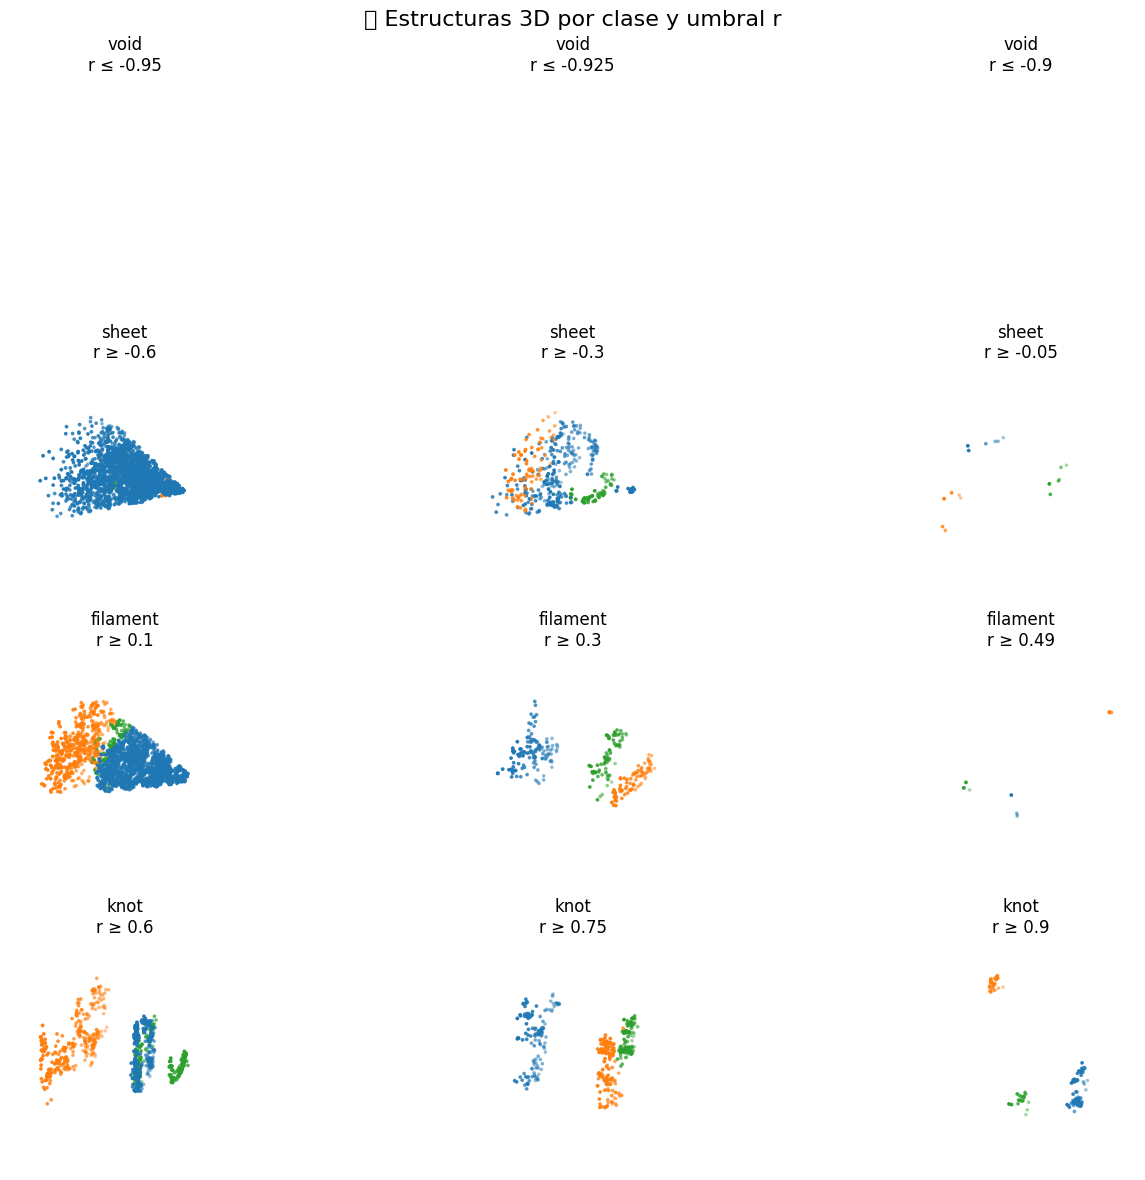

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22356\803234268.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22356\803234268.py:55: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


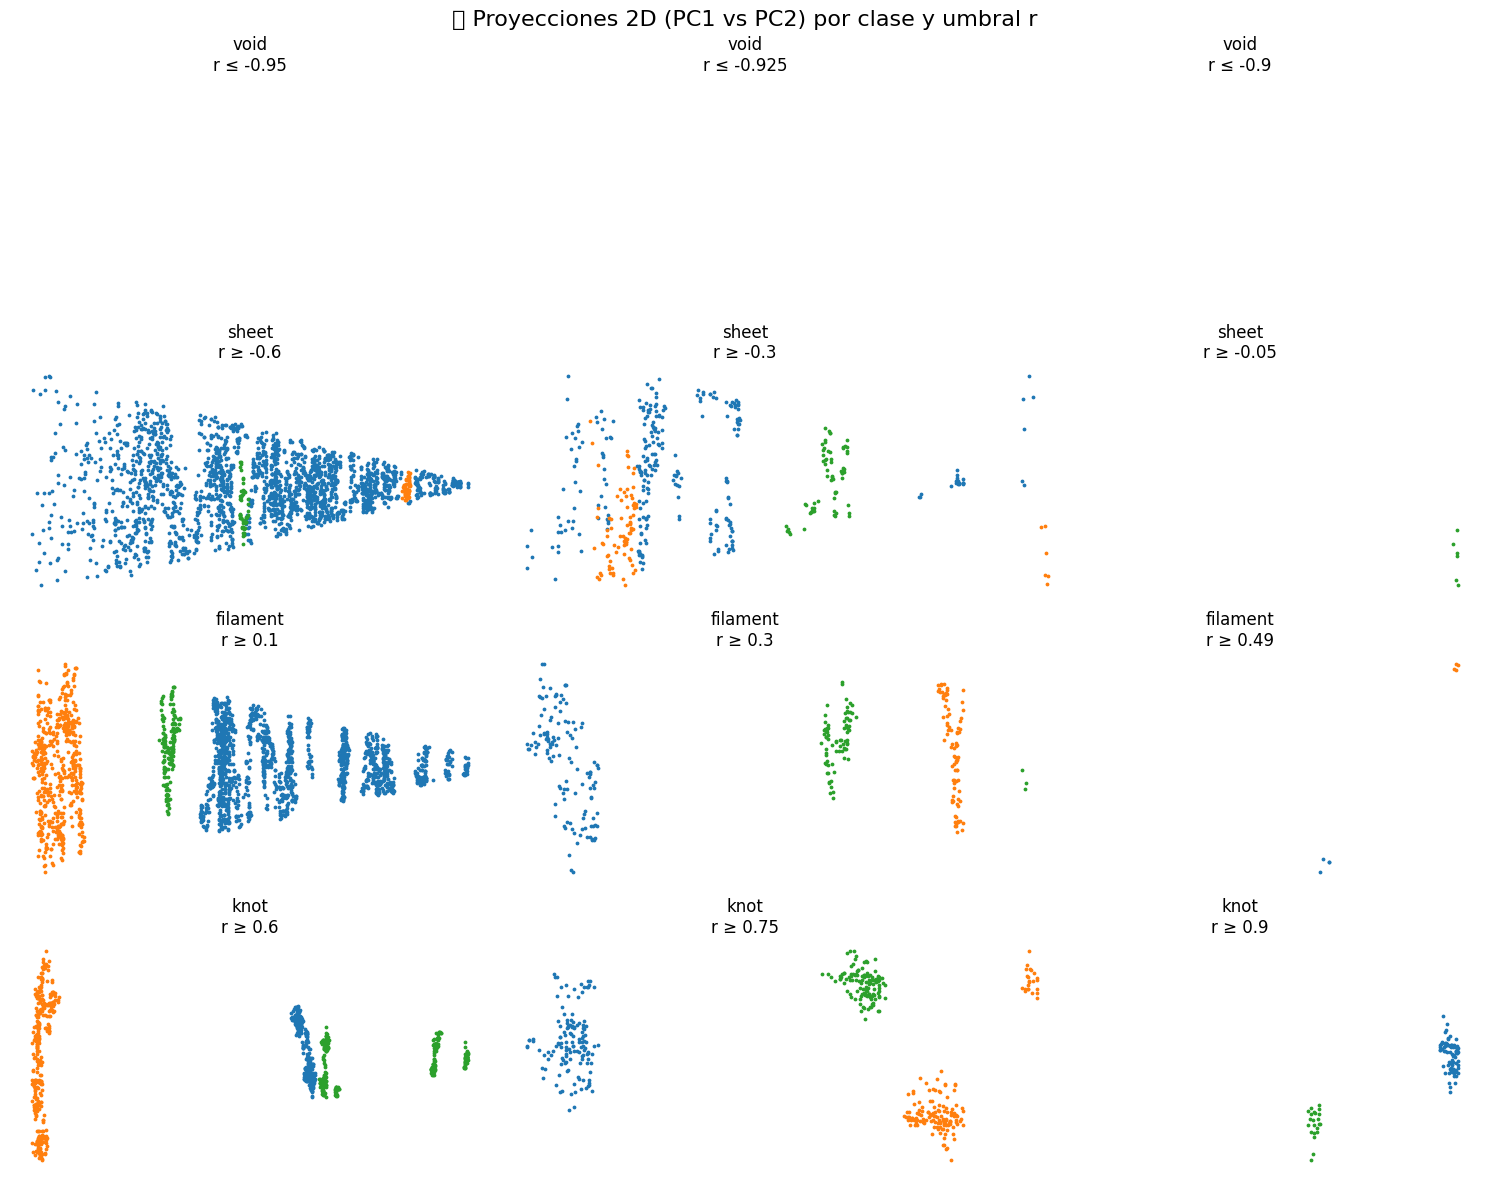

In [57]:
plot_3d_by_structure(data, pairs_data, count_data)
plot_2d_by_structure(data, pairs_data, count_data)

In [58]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
import numpy as np
from matplotlib import colormaps  # en lugar de cm.get_cmap

def plot_3d_by_structure_fixed(data, pairs_data, count_data):
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r_values = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

    def classify_r(r):
        if -1.0 <= r <= -0.9:
            return "void"
        elif -0.9 < r <= 0.0:
            return "sheet"
        elif 0.0 < r <= 0.5:
            return "filament"
        elif 0.5 < r <= 1.0:
            return "knot"
        return "unknown"
    classes = np.array([classify_r(r) for r in r_values])

    thresholds = {
        "void": [-0.95, -0.925, -0.9],
        "sheet": [-0.6, -0.3, -0.05],
        "filament": [0.1, 0.3, 0.49],
        "knot": [0.6, 0.75, 0.9]
    }

    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(data)
    id_to_pca = dict(zip(range(len(data)), coords_rotated))
    cmap = colormaps.get_cmap("tab10")

    fig = plt.figure(figsize=(15, 12))
    structure_list = ["void", "sheet", "filament", "knot"]

    for row, struct in enumerate(structure_list):
        for col, r_thresh in enumerate(thresholds[struct]):
            if struct == "void":
                valid_ids = np.where((classes == struct) & (r_values <= r_thresh))[0]
            else:
                valid_ids = np.where((classes == struct) & (r_values >= r_thresh))[0]
            valid_set = set(valid_ids)

            filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_set and b in valid_set]
            G = nx.Graph()
            G.add_edges_from(filtered_pairs)
            components = sorted(nx.connected_components(G), key=lambda x: -len(x))

            ax = fig.add_subplot(4, 3, row * 3 + col + 1, projection='3d')

            # Fondo: todos los puntos reales
            ax.scatter(coords_rotated[:, 0], coords_rotated[:, 1], coords_rotated[:, 2], 
                       s=1, color='black', alpha=0.1)

            # Componentes coloreadas
            for i, comp in enumerate(components[:3]):
                coords = np.array([id_to_pca[idx] for idx in comp])
                ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=4, color=cmap(i))

            ax.set_title(f"{struct} — {'r ≤' if struct=='void' else 'r ≥'} {r_thresh}")
            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_zlabel("PC3")
            ax.grid(True)

    fig.suptitle("Estructuras 3D por clase y umbral r", fontsize=16)
    plt.tight_layout()
    plt.show()

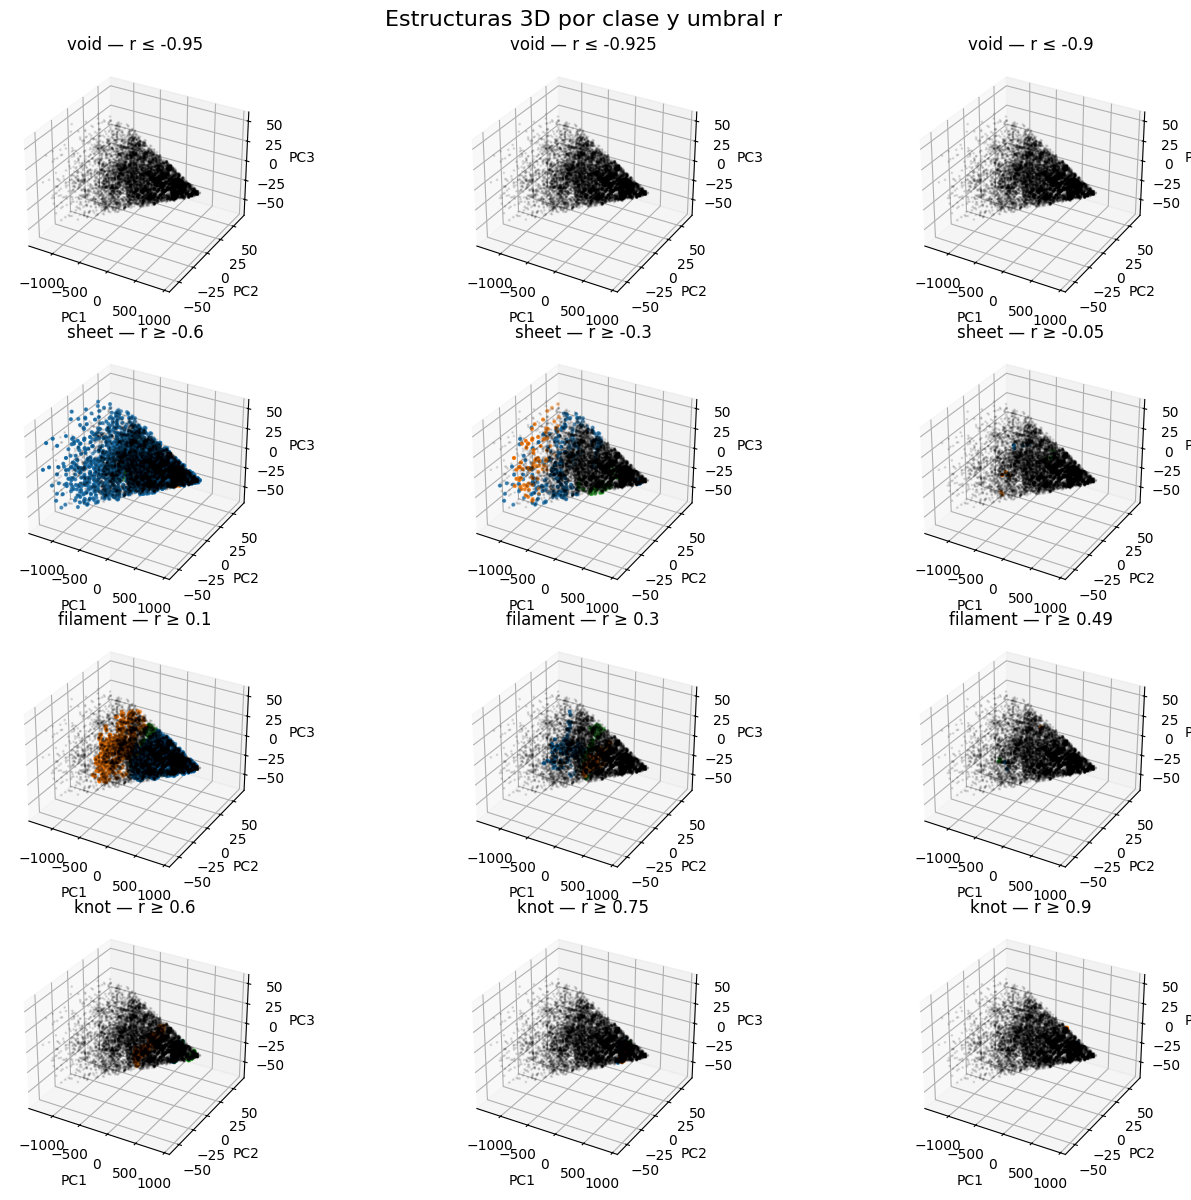

In [59]:
plot_3d_by_structure_fixed(data, pairs_data, count_data)

In [62]:
def plot_2d_by_structure_fixed(data, pairs_data, count_data):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    from matplotlib import colormaps

    # Calcular r
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r_values = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

    def classify_r(r):
        if -1.0 <= r <= -0.9:
            return "void"
        elif -0.9 < r <= 0.0:
            return "sheet"
        elif 0.0 < r <= 0.5:
            return "filament"
        elif 0.5 < r <= 1.0:
            return "knot"
        return "unknown"
    classes = np.array([classify_r(r) for r in r_values])

    thresholds = {
        "void": [-0.95, -0.925, -0.9],
        "sheet": [-0.6, -0.3, -0.05],
        "filament": [0.1, 0.3, 0.49],
        "knot": [0.6, 0.75, 0.9]
    }

    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(data)
    id_to_pca = dict(zip(range(len(data)), coords_rotated))
    cmap = colormaps.get_cmap("tab10")

    fig = plt.figure(figsize=(15, 12))
    structure_list = ["void", "sheet", "filament", "knot"]

    for row, struct in enumerate(structure_list):
        for col, r_thresh in enumerate(thresholds[struct]):
            if struct == "void":
                valid_ids = np.where((classes == struct) & (r_values <= r_thresh))[0]
            else:
                valid_ids = np.where((classes == struct) & (r_values >= r_thresh))[0]
            valid_set = set(valid_ids)

            filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_set and b in valid_set]
            G = nx.Graph()
            G.add_edges_from(filtered_pairs)
            components = sorted(nx.connected_components(G), key=lambda x: -len(x))

            ax = fig.add_subplot(4, 3, row * 3 + col + 1)

            # Fondo negro: todos los puntos reales
            ax.scatter(coords_rotated[:, 0], coords_rotated[:, 1], s=1, color='black', alpha=0.1)

            # Componentes conectados de esa clase
            for i, comp in enumerate(components[:3]):
                coords = np.array([id_to_pca[idx] for idx in comp])
                ax.scatter(coords[:, 0], coords[:, 1], s=4, color=cmap(i))

            ax.set_title(f"{struct} — {'r ≤' if struct=='void' else 'r ≥'} {r_thresh}")
            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.grid(True)

    fig.suptitle("Estructuras 2D BGS_Roseta 0 (PC1 vs PC2) por clase y umbral r", fontsize=16)
    plt.tight_layout()
    plt.show()


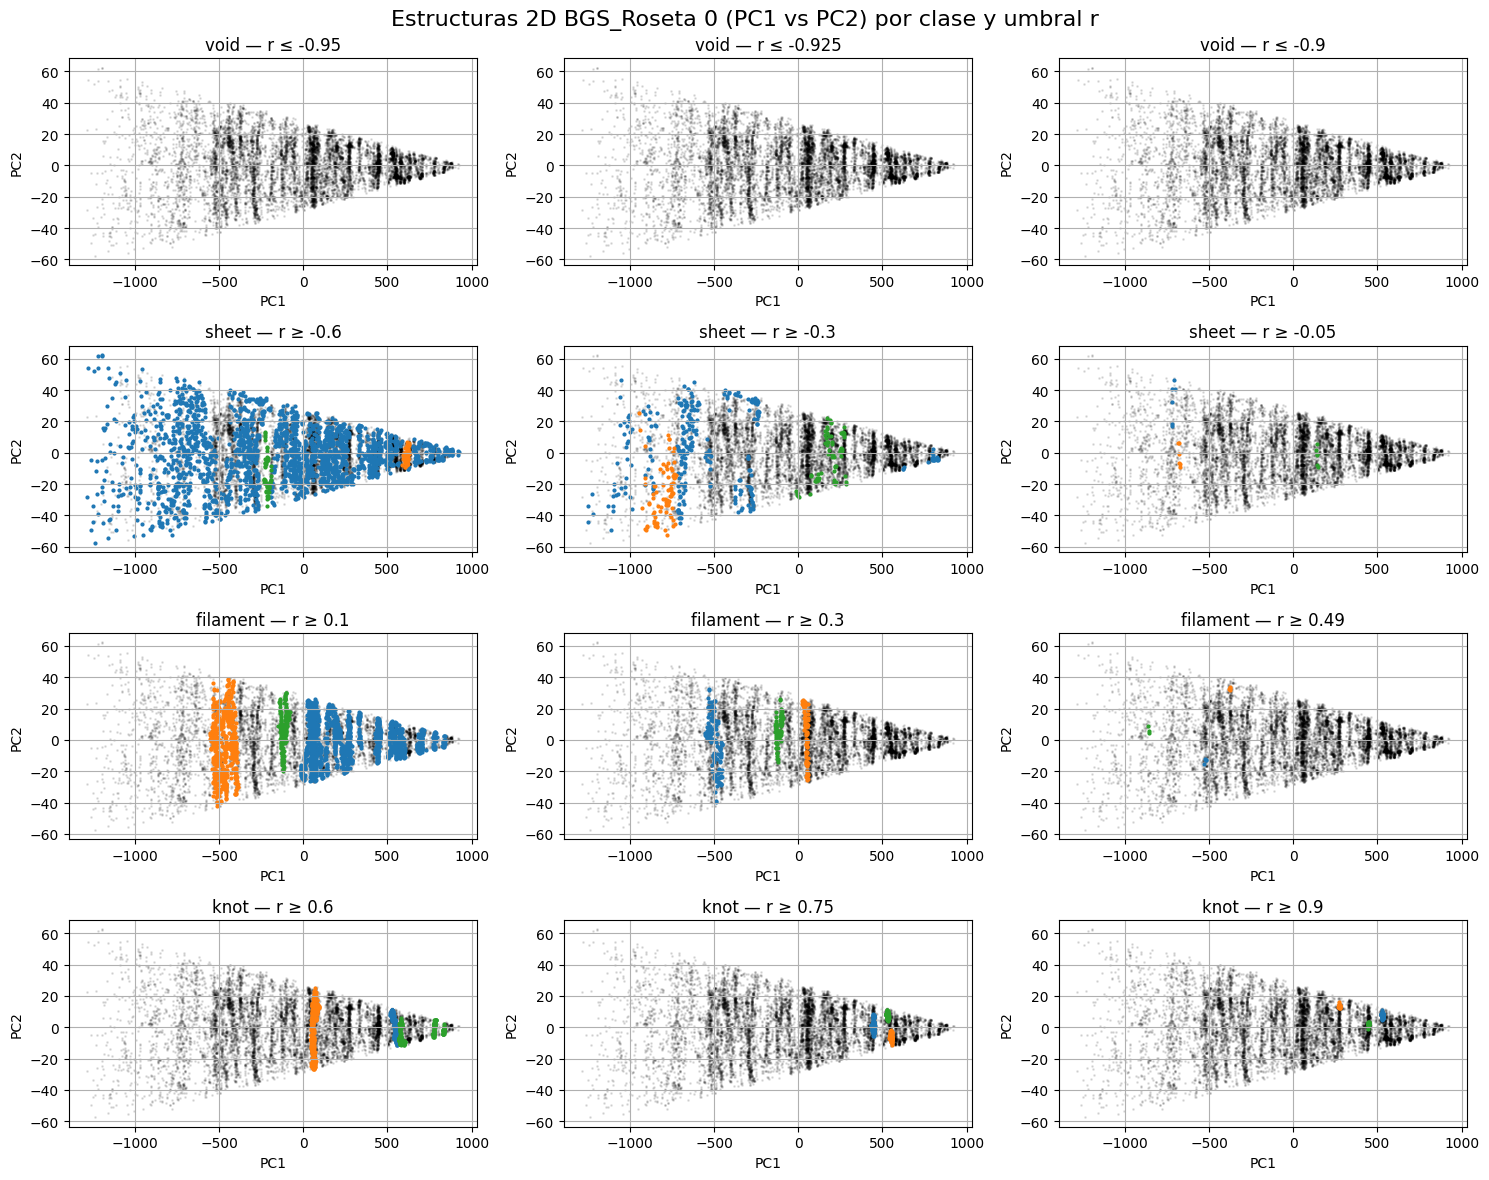

In [63]:
plot_2d_by_structure_fixed(data, pairs_data, count_data)

In [71]:
import os
import numpy as np
import pandas as pd
import networkx as nx

data_dir = r"C:\Users\USUARIO\Desktop\CosmicWeb_BGS_ASTRA\XYZ_outputs\XYZ_data"
random_dir = r"C:\Users\USUARIO\Desktop\CosmicWeb_BGS_ASTRA\06_astrology_random_MC\data_100_random"

def classify_r(r):
    if -1.0 <= r <= -0.9:
        return "void"
    elif -0.9 < r <= 0.0:
        return "sheet"
    elif 0.0 < r <= 0.5:
        return "filament"
    elif 0.5 < r <= 1.0:
        return "knot"
    return "unknown"

def analyze_rosetta(data, pairs_data, count_data, r_threshold=0.1):
    n_to_data = count_data[:, 0]
    n_to_rand = count_data[:, 1]
    r_values = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)
    classes = np.array([classify_r(r) for r in r_values])

    # Valid points above threshold
    valid_ids = set(np.where(r_values >= r_threshold)[0])
    filtered_pairs = [(a, b) for a, b in pairs_data if a in valid_ids and b in valid_ids]

    # Build graph
    G = nx.Graph()
    G.add_edges_from(filtered_pairs)
    components = sorted(nx.connected_components(G), key=lambda x: -len(x))

    # Component size stats
    n_components = len(components)
    top_sizes = [len(c) for c in components[:3]]
    total_in_graph = sum(len(c) for c in components)
    prop_in_graph = total_in_graph / len(data)

    # Class distribution
    counts = pd.Series(classes).value_counts(normalize=True) * 100
    void_pct = counts.get("void", 0)
    sheet_pct = counts.get("sheet", 0)
    filament_pct = counts.get("filament", 0)
    knot_pct = counts.get("knot", 0)

    return {
        "N_components": n_components,
        "Top_1": top_sizes[0] if len(top_sizes) > 0 else 0,
        "Top_2": top_sizes[1] if len(top_sizes) > 1 else 0,
        "Top_3": top_sizes[2] if len(top_sizes) > 2 else 0,
        "%_connected": round(100 * prop_in_graph, 2),
        "%_void": round(void_pct, 2),
        "%_sheet": round(sheet_pct, 2),
        "%_filament": round(filament_pct, 2),
        "%_knot": round(knot_pct, 2)
    }

# 💡 Cambia este número para más rosettas
N_rosettas = 5
results = []

for i in range(N_rosettas):
    print(f"Procesando rosetta {i}...")

    datafile = f"BGS_{i}_clustering_data.ecsv"
    randomfile = f"BGS_{i}clustering_random0.ecsv"

    # Cargar desde variables ya leídas o usa loadtxt si es necesario
    from astropy.table import Table

    data_table = Table.read(os.path.join(data_dir, datafile), format='ascii.ecsv')
    random_table = Table.read(os.path.join(random_dir, randomfile), format='ascii.ecsv')
    
    data = np.vstack([data_table['X'], data_table['Y'], data_table['Z']]).T
    random = np.vstack([random_table['X'], random_table['Y'], random_table['Z']]).T


    all_points = np.vstack([data, random])

    from scipy.spatial import Delaunay
    import itertools

    tri = Delaunay(all_points)
    pairs = []
    for simplex in tri.simplices:
        edges = list(itertools.combinations(simplex, 2))
        pairs.extend([tuple(sorted(e)) for e in edges])
    unique_pairs = np.unique(pairs, axis=0)

    n_d = len(data)
    n_r = len(random)
    n_to_data = np.zeros(n_d + n_r)
    n_to_rand = np.zeros(n_d + n_r)
    for a, b in unique_pairs:
        a_is_data = a < n_d
        b_is_data = b < n_d
        if a_is_data: n_to_data[b] += 1
        else:         n_to_rand[b] += 1
        if b_is_data: n_to_data[a] += 1
        else:         n_to_rand[a] += 1

    count_data = np.vstack([n_to_data[:n_d], n_to_rand[:n_d]]).T
    pairs_data = [pair for pair in unique_pairs if pair[0] < n_d and pair[1] < n_d]

    # Guardar diagnóstico
    stats = analyze_rosetta(data, pairs_data, count_data, r_threshold=0.1)
    stats["Rosetta"] = i
    results.append(stats)

# Crear DataFrame final
df_summary = pd.DataFrame(results).set_index("Rosetta")
display(df_summary)

Procesando rosetta 0...
Procesando rosetta 1...
Procesando rosetta 2...
Procesando rosetta 3...
Procesando rosetta 4...


,N_components,Top_1,Top_2,Top_3,%_connected,%_void,%_sheet,%_filament,%_knot
Rosetta,,,,,,,,,
0,79,4148,1165,486,62.99,0.28,32.08,35.76,31.88
1,86,1879,1360,965,62.33,0.31,31.89,37.65,30.15
2,84,1247,1244,1029,61.88,0.28,32.57,39.26,27.88
3,79,3142,1164,587,60.18,0.31,34.30,37.74,27.65
4,89,3146,1243,1075,62.47,0.33,32.25,36.58,30.83


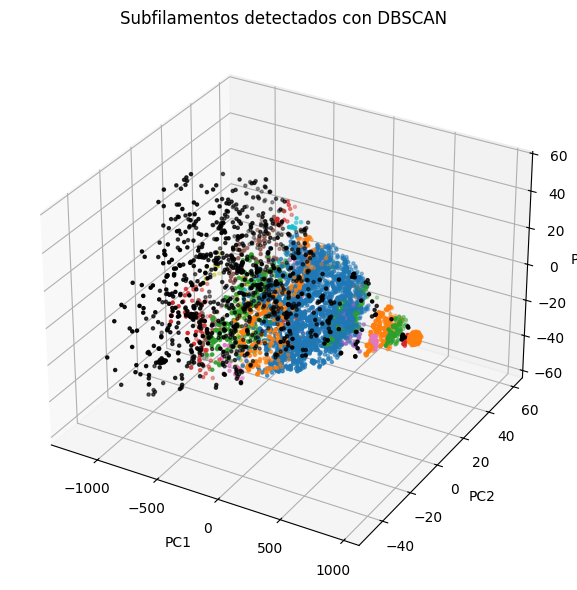

In [75]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Calcular r
n_to_data = count_data[:, 0]
n_to_rand = count_data[:, 1]
r_values = (n_to_data - n_to_rand) / (n_to_data + n_to_rand + 1e-8)

# 2. Filtrar puntos con r en rango de filamentos
filament_mask = (r_values > 0.0) & (r_values <= 0.5)
filament_coords = data[filament_mask]

# 3. DBSCAN sobre coordenadas (espacio físico, no PCA)
db = DBSCAN(eps=10, min_samples=10).fit(filament_coords)
labels = db.labels_

# 4. PCA para graficar
pca = PCA(n_components=3)
coords_pca = pca.fit_transform(filament_coords)

# 5. Visualización
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = labels == label
    color = 'black' if label == -1 else colors[i]
    ax.scatter(coords_pca[mask, 0], coords_pca[mask, 1], coords_pca[mask, 2],
               s=5, color=color, label=f'Cluster {label}' if label != -1 else 'Noise')

ax.set_title("Subfilamentos detectados con DBSCAN")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
#ax.legend()
plt.tight_layout()
plt.show()

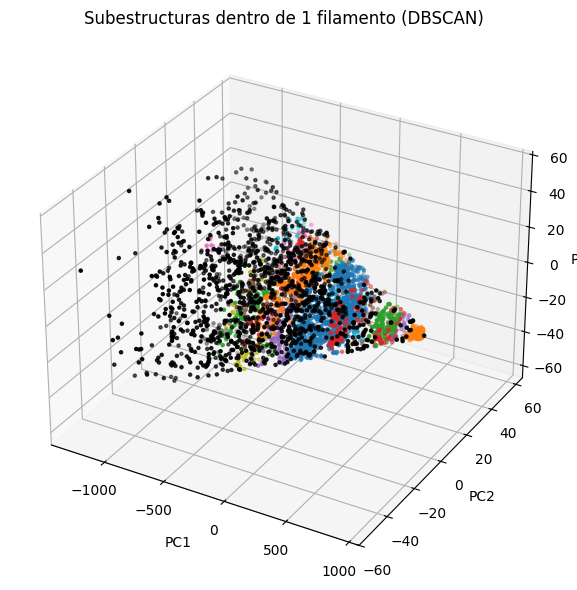

In [74]:
# Tomemos el segundo filamento más grande (por ejemplo)
filament_nodes = list(components[1])  # puedes cambiar el índice

# Coordenadas de ese filamento
filament_coords = data[filament_nodes]

# DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=10, min_samples=10).fit(filament_coords)
labels = db.labels_

# PCA para graficar
from sklearn.decomposition import PCA
coords_pca = PCA(n_components=3).fit_transform(filament_coords)

# Graficar clusters en el filamento
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = labels == label
    color = 'black' if label == -1 else colors[i]
    ax.scatter(coords_pca[mask, 0], coords_pca[mask, 1], coords_pca[mask, 2],
               s=5, color=color, label=f'Cluster {label}' if label != -1 else 'Noise')

ax.set_title("Subestructuras dentro de 1 filamento (DBSCAN)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
#ax.legend()
plt.tight_layout()
plt.show()


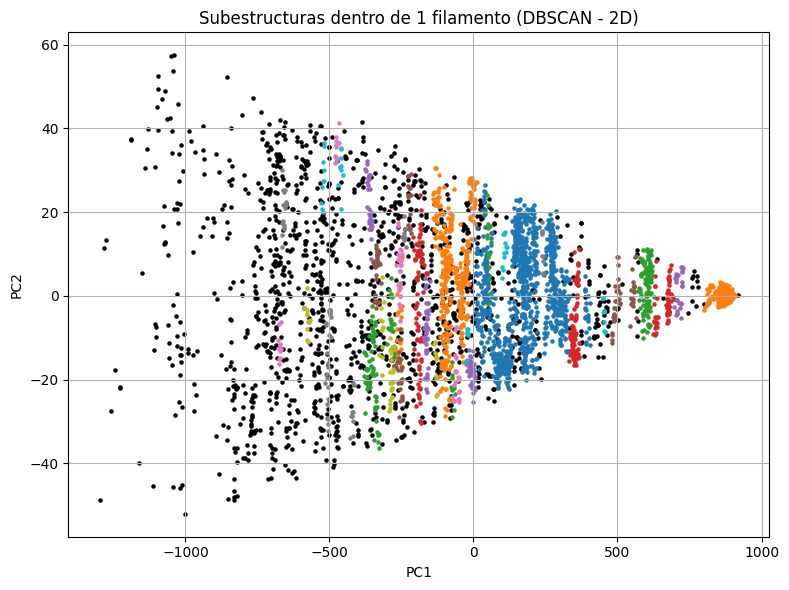

In [77]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Seleccionar el filamento que quieres analizar (por índice en components)
filament_nodes = list(components[1])  # cambia el índice para otros filamentos

# 2. Obtener coordenadas de ese filamento
filament_coords = data[filament_nodes]

# 3. Aplicar DBSCAN
db = DBSCAN(eps=10, min_samples=10).fit(filament_coords)
labels = db.labels_

# 4. Reducir a 2D (PC1 vs PC2) para graficar
pca = PCA(n_components=2)
coords_pca = pca.fit_transform(filament_coords)

# 5. Graficar en 2D
unique_labels = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    mask = labels == label
    color = 'black' if label == -1 else colors[i]
    plt.scatter(coords_pca[mask, 0], coords_pca[mask, 1],
                s=5, color=color, label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title("Subestructuras dentro de 1 filamento (DBSCAN - 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
